# [GD2] Resnet Augmentation with Cutmix and Mixup

* Data의 Augmentation 기법을 적용하여 데이터를 불러오고 Resnet 모델에 적용하여 학습을 해보자
* Augmentation 심화기법 중 Cutmix와 Mixup을 적용하여 각각 모델별 성능을 비교해보자

## 1. Stanford dogs Dataset 
 - 노드와 동일하게 imagenet 학습된 Resnet 모델 사용
 - no aug, augmentation, aug_cutmix, aug_mixup  확인
 - Epoch 20번 ~ 200번까지 학습

## 2. CIFAR-10 Dataset
 - GD1의 Resnet 모델 Baseline 구성 
 - no aug, augmentation, aug_cutmix, aug_mixup 확인
 - Epoch 20번 ~ 50번 학습 

### Augmentation 적용 데이터불러오기 - Stanford dogs
* 데이터는 Stanford_dogs 데이터셋으로 120개 견종의 이미지, 총 20,580장의 이미지에서 12,000장은 학습, 나머지 8,580장은 평가용 데이터셋이다.
* 텐서플로우에서 기본적으로 제공하는 Augmentation 기법이 있다. 
 - brightness(), contrast(), crop(), flip_left_right(), flight_up_down(), hue(), jpeg_quality(), saturation()

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

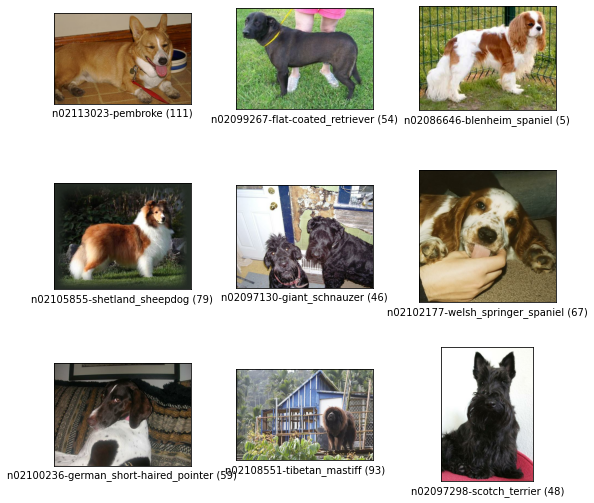

In [4]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
fig = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info.features["label"].num_classes

120

In [6]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [7]:
batch_size = 16

### 기본 전처리 함수
 * 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다
 * 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용됩니다.

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


### Augmentation 중 flip_left_right, brightness 사용
 *  "flip"의 경우 좌우 대칭, 상하대칭은 도움되지 않음
 *  "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응

In [9]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

#### 메인함수로 정의하되 주의해야할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 함. 

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=batch_size, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.

In [12]:
num_classes = ds_info.features["label"].num_classes

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [14]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # include_top은 마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

### Resnet 모델 학습
 * Resnet 50 모델에 Augmentation 데이터셋 적용과 적용하지 않은 모델 2개를 먼저 학습하여 성능을 확인해보자

In [16]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=1,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 110s 147ms/step - loss: 1.1356 - accuracy: 0.6902 - val_loss: 1.4204 - val_accuracy: 0.5894


In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### Cutmix Augmentation

 * Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. 
 * CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다. 
![GC-2-P-2 max-800x600](https://user-images.githubusercontent.com/38655888/115414042-ae387e80-a230-11eb-96fb-bc13600c113f.png)


In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

라벨섞기 :
강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.
CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

In [ ]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

In [ ]:
def cutmix(image, label, prob = 1.0, batch_size=batch_size, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Mixup Augmentation
 * 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있다. 
 * 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.
![GC-2-P-3 max-800x600](https://user-images.githubusercontent.com/38655888/115415523-f1dfb800-a231-11eb-95e3-38c1601e53f9.png)

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [ ]:
def mixup(image, label, prob = 1.0, batch_size=batch_size, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def onehot(image,label):
    CLASSES = 120
    return image,tf.one_hot(label,CLASSES)

AUTO = tf.data.experimental.AUTOTUNE


def get_validation_dataset(ds, do_onehot=True, batch_size=batch_size):
    ds = ds.batch(batch_size)
    if do_onehot: ds = ds.map(onehot, num_parallel_calls=2) # we must use one hot like augmented train data
    ds = ds.cache()
    ds = ds.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return ds

## 1. Cutmix/Mixup Augmentation을 적용한 데이터셋 만들기


In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [ ]:
def apply_normalize_on_dataset_cutmix(ds, is_test=False, batch_size=batch_size, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def apply_normalize_on_dataset_mixup(ds, is_test=False, batch_size=batch_size, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Augmentation 적용 비교하기
아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet에 훈련된 모델을 불러옵니다. include_top은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.


In [ ]:

aug2_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # include_top은 마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

aug3_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [ ]:
#ds_train_no_aug = apply_normalize_on_dataset_aug(ds_train, with_aug=False)
ds_train_aug_cutmix = apply_normalize_on_dataset_cutmix(ds_train, with_cutmix=True)
ds_test_aug_cutmix = apply_normalize_on_dataset_cutmix(ds_test, is_test = True)
ds_train_aug_mixup = apply_normalize_on_dataset_mixup(ds_train, with_mixup=True)
ds_test_aug_mixup = apply_normalize_on_dataset_mixup(ds_test, is_test = True)

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# sparse_categorical_crossentropy()를 사용하지 못하는 이유가
# 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문
EPOCH = 20


aug2_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug3_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_aug3_mixup_resnet50 = aug3_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test_aug_mixup,
    verbose=1,
    use_multiprocessing=True,
)

In [64]:
history_aug2_cutmix_resnet50 = aug2_cutmix_resnet50.fit(
    ds_train_aug_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test_aug_cutmix,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/200
  2/750 [..............................] - ETA: 1:22 - loss: 5.0887 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0512s vs `on_train_batch_end` time: 0.0798s). Check your callbacks.


750/750 [==============================] - 116s 154ms/step - loss: 3.8574 - accuracy: 0.2062 - val_loss: 3.6685 - val_accuracy: 0.1656
Epoch 2/200
750/750 [==============================] - 115s 153ms/step - loss: 2.9844 - accuracy: 0.4249 - val_loss: 1.3458 - val_accuracy: 0.6291
Epoch 3/200
750/750 [==============================] - 115s 153ms/step - loss: 2.6791 - accuracy: 0.5117 - val_loss: 1.3633 - val_accuracy: 0.6242
Epoch 4/200
750/750 [==============================] - 115s 153ms/step - loss: 2.4650 - accuracy: 0.5798 - val_loss: 1.2988 - val_accuracy: 0.6391
Epoch 5/200
750/750 [==============================] - 115s 153ms/step - loss: 2.3205 - accuracy: 0.6323 - val_loss: 1.2231 - val_accuracy: 0.6707
Epoch 6/200
750/750 [==============================] - 115s 153ms/step - loss: 2.2162 - accuracy: 0.6648 - val_loss: 1.1558 - val_accuracy: 0.6877
Epoch 7/200
750/750 [==============================] - 115s 153ms/step - loss: 2.1249 - accuracy: 0.6929 - val_loss: 1.2020 - val_

KeyboardInterrupt: 

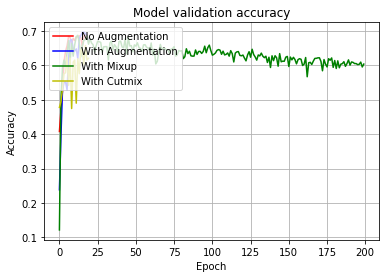

In [65]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_aug3_mixup_resnet50.history['val_accuracy'], 'g')
plt.plot(history_aug2_cutmix_resnet50.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation',  'With Mixup',  'With Cutmix'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

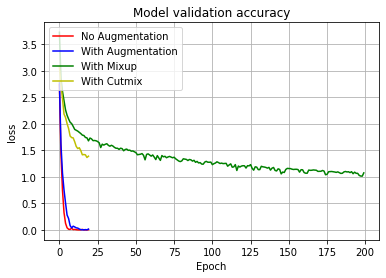

In [66]:
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_aug3_mixup_resnet50.history['loss'], 'g')
plt.plot(history_aug2_cutmix_resnet50.history['loss'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation',  'With Mixup',  'With Cutmix'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## CIFAR-10 Dataset

In [120]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train_cifar, ds_test_cifar), ds_info_cifar = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print(ds_info_cifar.features)


FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [121]:
def normalize_and_resize_img_cifar(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset_cifar_basic(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img_cifar,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [122]:
num_classes_cifar = ds_info_cifar.features["label"].num_classes

(ds_train_cifar, ds_test_cifar), ds_info_cifar = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset_cifar_basic(ds_train_cifar, with_aug=False)
ds_train_aug = apply_normalize_on_dataset_cifar_basic(ds_train_cifar, with_aug=True)
ds_test = apply_normalize_on_dataset_cifar_basic(ds_test_cifar, is_test=True)



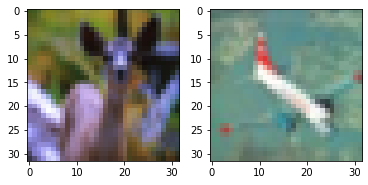

In [123]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [124]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(16, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(32, shape=(), dtype=int32) tf.Tensor(27, shape=(), dtype=int32)


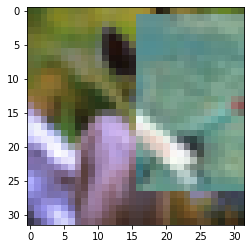

In [125]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [126]:
# mix two labels
def mix_2_label_cifar(label_a, label_b, xa, ya, xb, yb, num_classes=10):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label_cifar(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.40625, 0.     , 0.     , 0.     , 0.59375, 0.     , 0.     ,
       0.     , 0.     , 0.     ], dtype=float32)>

In [127]:
def cutmix_cifar(image, label, prob = 1.0, batch_size=16, img_size=32, num_classes=10):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label_cifar(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels


tf.Tensor(
[0.23119807 0.         0.         0.         0.7688019  0.
 0.         0.         0.         0.        ], shape=(10,), dtype=float32)


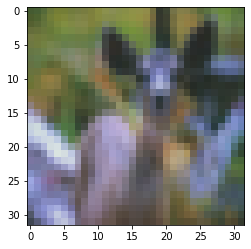

In [128]:
# function for mixup
def mixup_2_images_cifar(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes_cifar)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes_cifar)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images_cifar(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [129]:
def mixup_cifar(image, label, prob = 1.0, batch_size=16, img_size=32, num_classes=10):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images_cifar(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [130]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def onehot(image,label):
    CLASSES = 10
    return image,tf.one_hot(label,CLASSES)

AUTO = tf.data.experimental.AUTOTUNE

def apply_normalize_on_dataset_cutmix_for_cifar(ds, is_test=False, batch_size=16, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img_cifar, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix_cifar,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [131]:
def apply_normalize_on_dataset_mixup_for_cifar(ds, is_test=False, batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img_cifar, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup_cifar,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [132]:
# Resnet 50
# number of classes
K = 10
 
#input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet_50 = Model(input_tensor, output_tensor)
resnet_50_aug = Model(input_tensor, output_tensor)
resnet_50_cutmix = Model(input_tensor, output_tensor)
resnet_50_mixup = Model(input_tensor, output_tensor)
resnet_50.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 16, 16, 64)   9472        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
batch_normalization_265 (BatchN (None, 16, 16, 64)   256         conv2d_265[0][0]                 
______________________________________________________________________________________

In [133]:
aug_cutmix_resnet50_cifar = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # include_top은 마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(32, 32,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes_cifar, activation = 'softmax')
])

aug_resnet50_cifar = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(32, 32,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes_cifar, activation = 'softmax')
])

no_aug_resnet50_cifar = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(32, 32,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes_cifar, activation = 'softmax')
])

(ds_train_cifar, ds_test_cifar), ds_info_cifar = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [134]:
#ds_train_no_aug = apply_normalize_on_dataset_aug(ds_train, with_aug=False)
ds_train_aug_cutmix_cifar = apply_normalize_on_dataset_cutmix_for_cifar(ds_train_cifar, with_cutmix=True)
ds_test_aug_cutmix_cifar = apply_normalize_on_dataset_cutmix_for_cifar(ds_test_cifar, is_test = True)

In [135]:
ds_train_aug_mixup_cifar = apply_normalize_on_dataset_mixup_for_cifar(ds_train_cifar, with_mixup=True)
ds_test_aug_mixup_cifar = apply_normalize_on_dataset_mixup_for_cifar(ds_test_cifar, is_test = True)

In [136]:
EPOCH = 30

#tf.random.set_seed(2020)

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet_50_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet_50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet_50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


aug_cutmix_resnet50_cifar.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
aug_resnet50_cifar.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
no_aug_resnet50_cifar.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)



In [56]:
history_resnet_50 = resnet_50.fit(
    ds_train_no_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info_cifar.splits['train'].num_examples/16),
    validation_steps=int(ds_info_cifar.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.2635 - accuracy: 0.5595 - val_loss: 1.7026 - val_accuracy: 0.5558
Epoch 2/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.1927 - accuracy: 0.5820 - val_loss: 1.8435 - val_accuracy: 0.5754
Epoch 3/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.2062 - accuracy: 0.5791 - val_loss: 3.5963 - val_accuracy: 0.5400
Epoch 4/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.2289 - accuracy: 0.5689 - val_loss: 1.1731 - val_accuracy: 0.5976
Epoch 5/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.2258 - accuracy: 0.5700 - val_loss: 2.6622 - val_accuracy: 0.5208
Epoch 6/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.1328 - accuracy: 0.6015 - val_loss: 1.9014 - val_accuracy: 0.5990
Epoch 7/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.1596 - accuracy: 0.5968 - val_loss: 1.5526 -

In [57]:
history_resnet_50_aug = resnet_50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info_cifar.splits['train'].num_examples/16),
    validation_steps=int(ds_info_cifar.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
3125/3125 [==============================] - 74s 24ms/step - loss: 0.7317 - accuracy: 0.7526 - val_loss: 1.5642 - val_accuracy: 0.6660
Epoch 2/30
3125/3125 [==============================] - 72s 23ms/step - loss: 0.6903 - accuracy: 0.7625 - val_loss: 2.6734 - val_accuracy: 0.6689
Epoch 3/30
3125/3125 [==============================] - 72s 23ms/step - loss: 0.6581 - accuracy: 0.7717 - val_loss: 1.1830 - val_accuracy: 0.6456
Epoch 4/30
3125/3125 [==============================] - 73s 23ms/step - loss: 0.7528 - accuracy: 0.7401 - val_loss: 2.5320 - val_accuracy: 0.5985
Epoch 5/30
3125/3125 [==============================] - 72s 23ms/step - loss: 0.7648 - accuracy: 0.7333 - val_loss: 2.2391 - val_accuracy: 0.6586
Epoch 6/30
3125/3125 [==============================] - 73s 23ms/step - loss: 0.6511 - accuracy: 0.7716 - val_loss: 1.1138 - val_accuracy: 0.6823
Epoch 7/30
3125/3125 [==============================] - 72s 23ms/step - loss: 0.5939 - accuracy: 0.7937 - val_loss: 1.1091 -

In [58]:
history_resnet_50_cutmix = resnet_50_cutmix.fit(
    ds_train_aug_cutmix_cifar, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info_cifar.splits['train'].num_examples/16),
    validation_steps=int(ds_info_cifar.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_aug_cutmix_cifar,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
   1/3125 [..............................] - ETA: 50s - loss: 5.0717 - accuracy: 0.5000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0115s vs `on_train_batch_end` time: 0.0202s). Check your callbacks.


3125/3125 [==============================] - 73s 23ms/step - loss: 1.6594 - accuracy: 0.5382 - val_loss: 1.1750 - val_accuracy: 0.6830
Epoch 2/30
3125/3125 [==============================] - 73s 23ms/step - loss: 1.5735 - accuracy: 0.5610 - val_loss: 1.3937 - val_accuracy: 0.6833
Epoch 3/30
3125/3125 [==============================] - 72s 23ms/step - loss: 1.4847 - accuracy: 0.6055 - val_loss: 1.1919 - val_accuracy: 0.6887
Epoch 4/30
3125/3125 [==============================] - 72s 23ms/step - loss: 1.5299 - accuracy: 0.5843 - val_loss: 1.3419 - val_accuracy: 0.6890
Epoch 5/30
3125/3125 [==============================] - 72s 23ms/step - loss: 1.5235 - accuracy: 0.5821 - val_loss: 1.0514 - val_accuracy: 0.6892
Epoch 6/30
3125/3125 [==============================] - 72s 23ms/step - loss: 1.4836 - accuracy: 0.6011 - val_loss: 1.7461 - val_accuracy: 0.6739
Epoch 7/30
3125/3125 [==============================] - 72s 23ms/step - loss: 1.5026 - accuracy: 0.5930 - val_loss: 1.4068 - val_accura

In [137]:
history_resnet_50_mixup = resnet_50_mixup.fit(
    ds_train_aug_mixup_cifar, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info_cifar.splits['train'].num_examples/16),
    validation_steps=int(ds_info_cifar.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_aug_mixup_cifar,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
3125/3125 [==============================] - 72s 23ms/step - loss: 3.2134 - accuracy: 0.2106 - val_loss: 29.3168 - val_accuracy: 0.3067
Epoch 2/30
3125/3125 [==============================] - 72s 23ms/step - loss: 2.6197 - accuracy: 0.2701 - val_loss: 10.5269 - val_accuracy: 0.3537
Epoch 3/30
3125/3125 [==============================] - 72s 23ms/step - loss: 2.3657 - accuracy: 0.3197 - val_loss: 3.5653 - val_accuracy: 0.4415
Epoch 4/30
3125/3125 [==============================] - 74s 24ms/step - loss: 2.2345 - accuracy: 0.3511 - val_loss: 146.9548 - val_accuracy: 0.2538
Epoch 5/30
3125/3125 [==============================] - 73s 23ms/step - loss: 2.1663 - accuracy: 0.3620 - val_loss: 13.2262 - val_accuracy: 0.4144
Epoch 6/30
3125/3125 [==============================] - 73s 23ms/step - loss: 2.0641 - accuracy: 0.3946 - val_loss: 119.7989 - val_accuracy: 0.1994
Epoch 7/30
3125/3125 [==============================] - 73s 23ms/step - loss: 2.0737 - accuracy: 0.3853 - val_loss: 2

In [ ]:
history_no_aug_resnet50_cifar = no_aug_resnet50_cifar.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info_cifar.splits['train'].num_examples/16),
    validation_steps=int(ds_info_cifar.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)



In [96]:
history_aug_resnet50_cifar = aug_resnet50_cifar.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info_cifar.splits['train'].num_examples/16),
    validation_steps=int(ds_info_cifar.splits['test'].num_examples/16),
    epochs=30,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
3125/3125 [==============================] - 74s 24ms/step - loss: 0.7914 - accuracy: 0.7295 - val_loss: 0.7882 - val_accuracy: 0.7342
Epoch 2/30
3125/3125 [==============================] - 73s 24ms/step - loss: 0.6534 - accuracy: 0.7769 - val_loss: 0.7426 - val_accuracy: 0.7434
Epoch 3/30
3125/3125 [==============================] - 73s 23ms/step - loss: 0.5398 - accuracy: 0.8141 - val_loss: 0.7398 - val_accuracy: 0.7590
Epoch 4/30
3125/3125 [==============================] - 73s 23ms/step - loss: 0.4494 - accuracy: 0.8453 - val_loss: 0.6374 - val_accuracy: 0.7930
Epoch 5/30
3125/3125 [==============================] - 73s 23ms/step - loss: 0.3738 - accuracy: 0.8704 - val_loss: 0.6589 - val_accuracy: 0.7977
Epoch 6/30
3125/3125 [==============================] - 74s 24ms/step - loss: 0.3180 - accuracy: 0.8901 - val_loss: 0.6954 - val_accuracy: 0.7926
Epoch 7/30
3125/3125 [==============================] - 73s 23ms/step - loss: 0.2651 - accuracy: 0.9070 - val_loss: 0.7159 -

In [84]:
history_aug_cutmix_resnet50_cifar = aug_cutmix_resnet50_cifar.fit(
    ds_train_aug_cutmix_cifar, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info_cifar.splits['train'].num_examples/16),
    validation_steps=int(ds_info_cifar.splits['test'].num_examples/16),
    epochs=50,
    validation_data=ds_test_aug_cutmix_cifar,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
3125/3125 [==============================] - 73s 23ms/step - loss: 2.2030 - accuracy: 0.2706 - val_loss: 3.0922 - val_accuracy: 0.3611
Epoch 2/50
3125/3125 [==============================] - 72s 23ms/step - loss: 1.9371 - accuracy: 0.3631 - val_loss: 1.6332 - val_accuracy: 0.4250
Epoch 3/50
3125/3125 [==============================] - 73s 23ms/step - loss: 1.8636 - accuracy: 0.3979 - val_loss: 1.2460 - val_accuracy: 0.5760
Epoch 4/50
3125/3125 [==============================] - 73s 23ms/step - loss: 1.7873 - accuracy: 0.4381 - val_loss: 1.4146 - val_accuracy: 0.5587
Epoch 5/50
3125/3125 [==============================] - 73s 23ms/step - loss: 1.7488 - accuracy: 0.4594 - val_loss: 2.2385 - val_accuracy: 0.2902
Epoch 6/50
3125/3125 [==============================] - 74s 24ms/step - loss: 1.7341 - accuracy: 0.4680 - val_loss: 1.1054 - val_accuracy: 0.6444
Epoch 7/50
3125/3125 [==============================] - 73s 23ms/step - loss: 1.6836 - accuracy: 0.4945 - val_loss: 1.1675 -

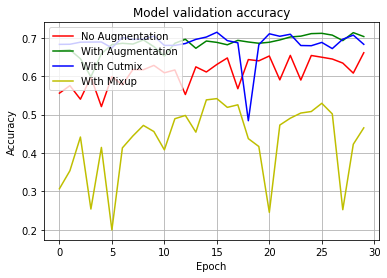

In [138]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet_50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet_50_mixup.history['val_accuracy'], 'y')
#plt.plot(history_no_aug_resnet50_cifar.history['val_accuracy'], 'b')
#plt.plot(history_aug_resnet50_cifar.history['val_accuracy'], 'y')
#plt.plot(history_aug_cutmix_resnet50_cifar.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력b하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, b0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

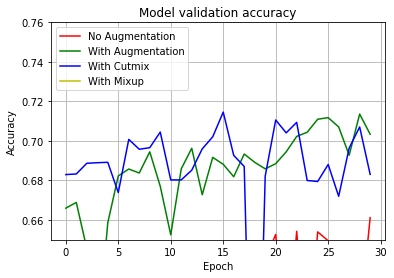

In [139]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet_50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet_50_mixup.history['val_accuracy'], 'y')
#plt.plot(history_no_aug_resnet50_cifar.history['val_accuracy'], 'b')
#plt.plot(history_aug_resnet50_cifar.history['val_accuracy'], 'y')
#plt.plot(history_aug_cutmix_resnet50_cifar.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력b하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.65, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

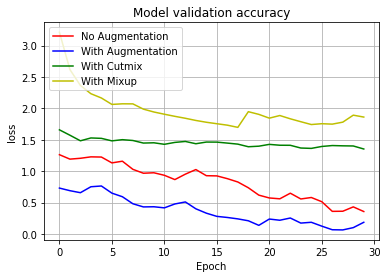

In [140]:
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_resnet_50_aug.history['loss'], 'b')
plt.plot(history_resnet_50_cutmix.history['loss'], 'g')
plt.plot(history_resnet_50_mixup.history['loss'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
-CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
-Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
-기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

## 결과
 - stanford dog 데이터셋은 mixup, cutmix에서 성능이 떨어졌다. 
 - 200번 이상 학습을 해보았으나 큰 차이는 없었다.
 - imagenet의 학습된 Resnet모델이 아닌 [GD1]에서 구성하 Resnet모델을 사용해보았다.
 - CIFAR-10 데이터셋으로 32x32x3 크기로 학습을 하였다.
 - Cutmix 기법으로 5% 이상 성능이 향상됨을 확인할 수 있었다. 
 - Mixup은 오히려 성능이 떨어졌다.

 #### Stanford dog의 결과로 유추해보았을때 데이터셋에 따라 Augmentation이 성능을 더 좋게할 수도 있고 나빠질 수도 있음을 알 수 있다. 논문에서의 mixup, cutmix의 기법은 이론과 실험적으로는 성능이 높아진다고 할 수 있으나 데이터의 대상의 위치와 배경 등에 따라 오히려 안좋아질 수 있으므로 Augmentation 기법을 사용할 시 주의해야함을 알 수 있었다. 
  
 #### 다음 논문을 통해 여러 데이터셋과 Augmentation기법에 따라 성능차이를 확인할 수 있었다.[1905.04899] https://arxiv.org/pdf/1905.04899.pdf Cutmix: Regularization Strategy to Train Strong Classifiers with ...

 #### 직관적으로 mixup 기법이 가장 높은 성능을 낼 수 있을것이라 생각했지만 cutmix가 가장 좋은 성능을 내는 기법이라는데 놀라웠다. GD1의 Resnet을 이번 노드에서도 사용해볼 수 있어서 의미가 있었고 앞으로의 다른 노드에서도 발전시키면서 모델에 대한 이해도를 높여가면 좋을것같다.